# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Behavioral cloning

In this project our assignment was to drive the car in the simulator provided by Udacity. First part of the assignment was collecting training data (screenshots and steering angels) by driving the simulator and the second part was training the neural network model that will drive the simulator by itself with help of Keras.

## Collecting training data

At first I have created my own training data but at the end I have decided for the training data provided by Udacity as it performed better than my own training data generated in the Udacity's driving simulator.

## Importing required Python packages

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import cv2
import math

from keras import initializations
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras.layers import Input, ELU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

import tensorflow as tf
tf.python.control_flow_ops = tf

from pathlib import Path
import json


## Data loading and preparation

First I have loaded the data from the driving_log.csv file with help of Pandas read_csv function and remove values with low speed where throttle was less than 0.20. I have smoothed the steering values as well as preparation for the model training.

In [5]:
# Imorting the driving log
csv_file = 'data/driving_log.csv'
driving_log = pd.read_csv(csv_file, header =0, index_col = False)

# Removing low speeds
ind = driving_log['throttle']>.20
driving_log= driving_log[ind].reset_index()


# Preparing steering data
smooth_steering = np.array(driving_log.steering,dtype=np.float32)
driving_log['steer_smooth'] = pd.Series(smooth_steering, index=driving_log.index)

## Input images augmentation, resizing and preprocessing before training

This was the most complex part of the project. Based on feedback from Slack channel #p-behavioral-cloning and numerous blogs from Udacity self driving car students I have decided to resize images to format 64 x 64 pixels. I have removed top 1/4 of the image to remove skyline and threes because they have not contained any valuable information for model training.

I have randomly shifted images by using WarpAffine function (to avoid overfitting), randomly augmented image brightness and randomly choose camera angle (between center, left and right) as well. Last augmentation was randomly flipping images and multiplying steering angle by -1. Randomly switching cameras between left, right and center was important to make the model more robust for correcting the car route when it deviates from the center.

In [7]:
#Determining imput image shape
image = cv2.imread(driving_log['center'][0].strip())
rows,cols,channels = image.shape

# Size in pixels to which imput image will be resized
input_image_size_col = 64
input_image_size_row = 64

# Cutting of irrelevant area of the image (skyline) and resizing image for model training.
def preprocess_image(image):
    shape = image.shape
    image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(input_image_size_col,input_image_size_row), interpolation=cv2.INTER_AREA)    
    return image 

# Augmenting brightness of images for driving in shadows or night
def augment_brightness_of_image(image):
    image_bright = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image_bright[:,:,2] = image_bright[:,:,2]*random_bright
    image_bright = cv2.cvtColor(image_bright,cv2.COLOR_HSV2RGB)
    return image_bright

# Shifting image by using warpAffine function
def transform_image(image,steer,trans_range):
    transform_x = trans_range*np.random.uniform()-trans_range/2
    steering_angle = steer + transform_x/trans_range*2*.2
    tr_y = 10*np.random.uniform()-10/2
    transformation_matrix = np.float32([[1,0,transform_x],[0,1,tr_y]])
    image_transformed = cv2.warpAffine(image,transformation_matrix,(cols,rows))
    
    return image_transformed,steering_angle,transform_x

# Preprocessing image for model training
def preprocess_image_file_train(line_data):
    #Choosing one random camera side
    random_camera = np.random.randint(3)
    if (random_camera == 0):
        imported_image = line_data['left'][0].strip()
        shift_angle = .25
    if (random_camera == 1):
        imported_image = line_data['center'][0].strip()
        shift_angle = 0.
    if (random_camera == 2):
        imported_image = line_data['right'][0].strip()
        shift_angle = -.25
    swifted_steering_angle = line_data['steer_smooth'][0] + shift_angle
    image = cv2.imread(imported_image)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image,swifted_steering_angle,transform_x = transform_image(image,swifted_steering_angle,150)
    image = augment_brightness_of_image(image)
    image = preprocess_image(image)
    image = np.array(image)
    #randomly inverse image for additional augmentation
    randomly_inverse_image = np.random.randint(2)
    if randomly_inverse_image==1:
        image = cv2.flip(image,1)
        swifted_steering_angle = -swifted_steering_angle
        
    return image,swifted_steering_angle

### Image preprocessing: Cutting top of the image and resizing it to 32 x 32 pixels

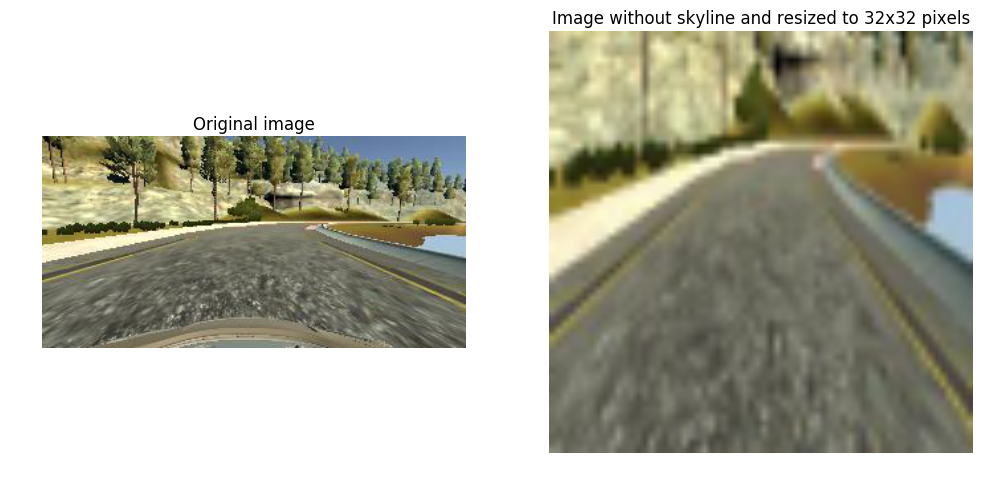

In [94]:
image = cv2.imread(driving_log['center'][200].strip())
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image/255.-.5

preprocessed_image = preprocess_image(image)

plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.imshow(image+.5);
plt.axis('off')
plt.title('Original image');
plt.subplot(1,2,2)
plt.imshow(preprocessed_image+.5);
plt.axis('off')
plt.title('Image without skyline and resized to 32x32 pixels');

### Image augmentation: Swifting image

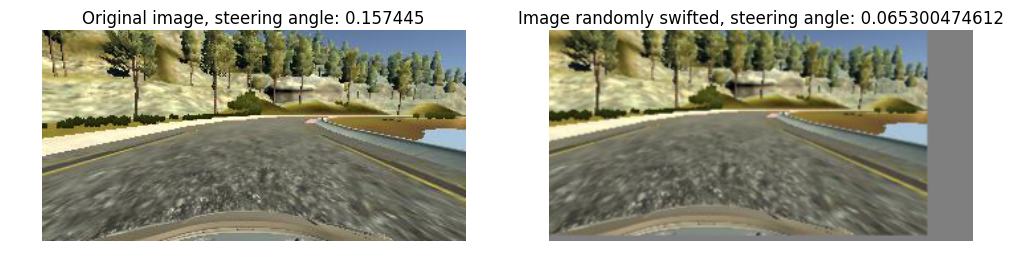

In [87]:
image_transformed,swifted_steering_angle,transform_x = transform_image(image,driving_log['steer_smooth'][200],150)
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.imshow(image+.5);
plt.axis('off')
plt.title('Original image, steering angle: ' + str(driving_log['steer_smooth'][200]) );  
plt.subplot(1,2,2)
plt.imshow(image_transformed+.5);
plt.axis('off')
plt.title('Image randomly swifted, steering angle: ' + str(swifted_steering_angle) );                                                           

### Image augmentation: Randomly augment image brightness

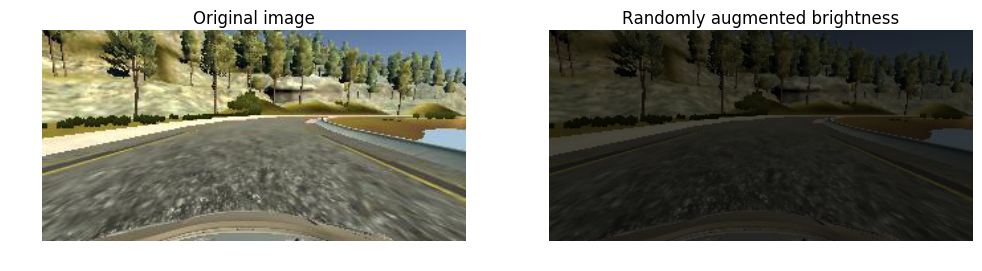

In [101]:
image = cv2.imread(driving_log['center'][200].strip())
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_brightened = augment_brightness_of_image(image)
image = image/255.-.5
image_brightened=image_brightened/255.-.5
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.imshow(image+.5);
plt.axis('off')
plt.title('Original image');  
plt.subplot(1,2,2)
plt.imshow(image_brightened+.5);
plt.axis('off')
plt.title('Randomly augmented brightness');      

### Image augmentation: Inverting image

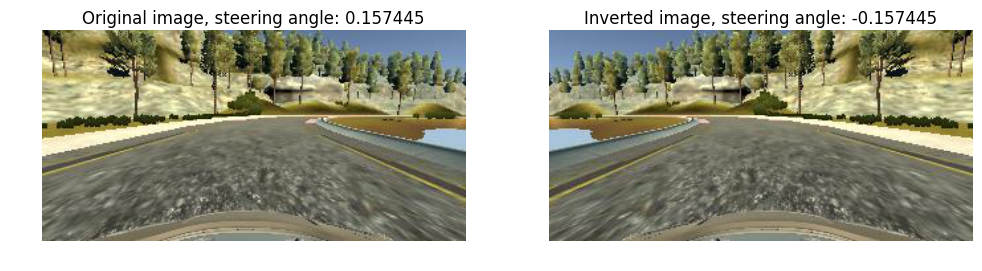

In [115]:
image = cv2.imread(driving_log['center'][200].strip())
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image/255.-.5
image_flipped = cv2.flip(image,1)
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.imshow(image+.5);
plt.axis('off')
plt.title('Original image, steering angle: ' + str(driving_log['steer_smooth'][200]) );  
plt.subplot(1,2,2)
plt.imshow(image_flipped+.5);
plt.axis('off')
plt.title('Inverted image, steering angle: ' + str(-driving_log['steer_smooth'][200]) );   


### Image augmentation and preprocessing: Putting it all together

Bellow are shown the examples of random images from the training set on which have been applied all previously described modifications.

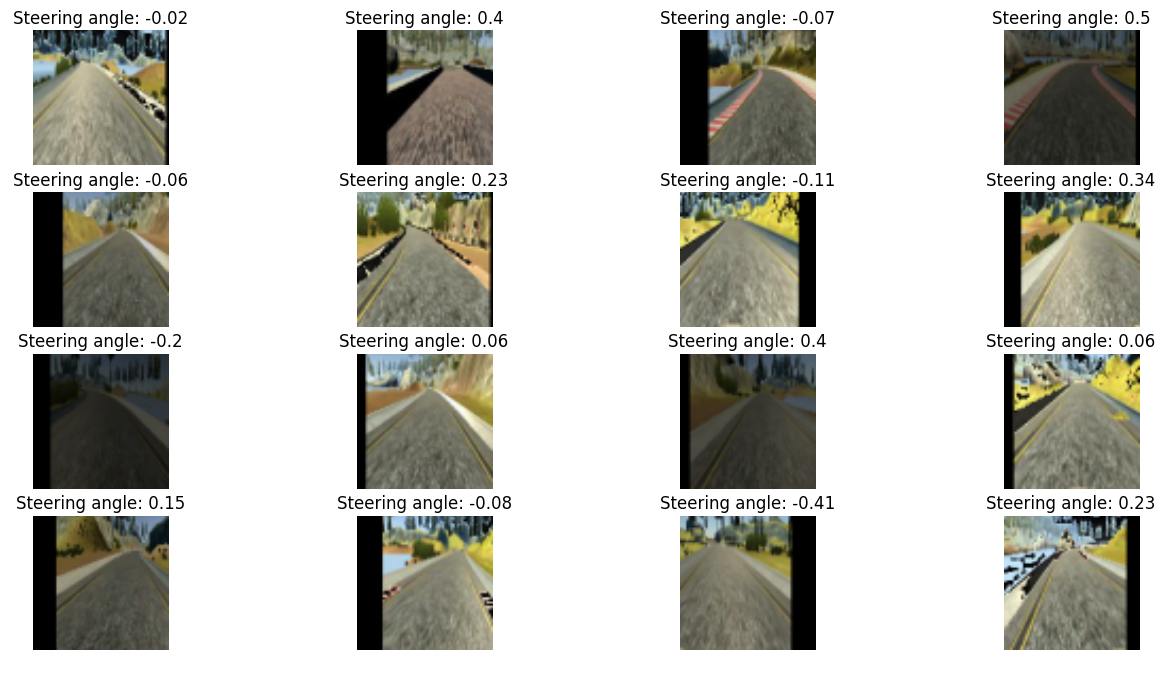

In [109]:
plt.figure(figsize=(16,8))
for i in range(16):
    random_integer = np.random.randint(len(driving_log))
    line_data = driving_log.iloc[[random_integer]].reset_index()
    image,steer = preprocess_image_file_train(line_data)
    plt.subplot(4,4,i+1)
    plt.imshow(image);
    plt.axis('off')
    plt.title('Steering angle: '+str(np.round(steer,2)))

## Training and validation data generators



I have used generators to generate the data for the model training and validation. I decided for generators to save the memory (as suggested by Udacity) by not to loading all of the images at into memory once. Generators are pretty basic, they pick one random image, preprocess it and return it with it's steering angle.

Train data generator has one additional parameter "batch", as training was done in batches (batch of 256 was used in this case). I have used this batch size because larger batch sizes can cause memory issues and smaller batch sizes take longer time to train.

In [116]:
# Preprocess image for predicting (no augmentation)
def preprocess_image_for_predicting(line_data):
    imported_image = line_data['center'][0].strip()
    image = cv2.imread(imported_image)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = preprocess_image(image)
    image = np.array(image)
    return image

# Random batch generator of input images and steering angles
def train_data_batch_generator(data, batch_size):
    batch_images = np.zeros((batch_size, input_image_size_row, input_image_size_col, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            x,y = preprocess_image_file_train(line_data)
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering

# Generate input images and steering angles for validation
def generate_validation_data(data):
    while 1:
        for i_line in range(len(data)):
            line_data = data.iloc[[i_line]].reset_index()
            x = preprocess_image_for_predicting(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = line_data['steer_smooth'][0]
            y = np.array([[y]])
            yield x, y
            

## Neural network model

As suggested from my mentor Denise, I have decided for NVIDIA convolutional neural network model. This network consists of 9 layers including normalisation layer, 5 convolutional layers and 3 fully connected layers. 

Graphic representation of NVIDIA convolutional neural network model has been shown bellow (Source: End to End Learning for Self-Driving Cars, NVIDIA)

<img src="NVIDIA_CNN.png" width="400">

In [ ]:
#NVIDIA neural network model
input_shape = (input_image_size_row, input_image_size_col, 3)
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1. , input_shape = input_shape))
model.add(Convolution2D(24,5,5, subsample=(2,2), border_mode="valid", init='he_normal'))
model.add(ELU())
model.add(Convolution2D(36,5,5, subsample=(2,2), border_mode="valid", init='he_normal'))
model.add(ELU())
model.add(Convolution2D(48,5,5, subsample=(2,2), border_mode="valid", init='he_normal'))
model.add(ELU())
model.add(Convolution2D(64,3,3, subsample=(1,1), border_mode="valid", init='he_normal'))
model.add(ELU())
model.add(Convolution2D(64,3,3, subsample=(1,1), border_mode="valid", init='he_normal'))
model.add(ELU())
model.add(Flatten())
model.add(Dense(1164, init='he_normal'))
model.add(ELU())
model.add(Dense(100, init='he_normal'))    
model.add(ELU())
model.add(Dense(50, init='he_normal'))
model.add(ELU())
model.add(Dense(10, init='he_normal'))
model.add(ELU())
model.add(Dense(1, init='he_normal'))



## Model training

For model training I have used Adam optimizer.

I have used batch of 256 and trained the model based upon 20224 samples per epoch.

After each epoch I have saved the model to be able to compare witch model performs best at the end. I have decided for the model from last iteration (epoch 10) because it performed best, even though validation loss was higher than in preceding iterations. 

After I have decided for the model I have renamed it to model.json with its weights renamed to model.h5 .

Input generators that I have used to train and validate the model have been described previously.

In [ ]:
# Adam optimizer
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam,loss='mse')

# Save keras model to disk
def save_keras_model(file_model_json,file_weights):
    if Path(file_model_json).is_file():
        os.remove(file_model_json)
    json_string = model.to_json()
    with open(file_model_json,'w' ) as f:
        json.dump(json_string, f)
    if Path(file_weights).is_file():
        os.remove(file_weights)
    model.save_weights(file_weights)
    
batch_size = 256

validation_data_generator = generate_validation_data(driving_log)

# Train model
for i_model_number in range(10):

    train_data_generator = train_data_batch_generator(driving_log,batch_size)

    history = model.fit_generator(train_data_generator,
            samples_per_epoch=20224, nb_epoch=1,validation_data=validation_data_generator,
                        nb_val_samples=len(driving_log))
    
    file_model_json = 'model_' + str(i_model_number) + '.json'
    file_weights = 'model_' + str(i_model_number) + '.h5'
    
    save_keras_model(file_model_json,file_weights)
    
    val_loss = history.history['val_loss'][0]

## Driving the Udacity's simulator with the trained model

To be able to drive the simulator with the trained model it was necessary to preprocess input images from the simulator first in drive.py file as follows:

In [129]:
# Converting input images to fit the model.
def preprocess_image(image):
    shape = image.shape
    image = image[shape[0]/4:shape[0]-25, 0:shape[1]]
    image = cv2.resize(image, (64,64), interpolation=cv2.INTER_AREA)
    return image

## Conclusion

This was very interesting project because we actually needed to train the model that interacts with the real time simulation, which puts us closer to real challenges that self driving car engineers face. It was also interesting to see that lowest validation loss does not necessary performs best in practice. Even though the project was challenging and required lots of experimenting with data augmentation, I was enjoying the project mainly because all the neural network theory finally starts making sense in real world.